## calibration Metrics
- Reliability Plot
- Calibration error
    - Expected Calibration Error
    - Maximum Calibration Error

## Regression Problems

In [5]:
import plotly
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [4]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
#quantile_mark = lambda x: df.quantile(x, interpolation="higher")
quantile_mark = lambda x: df.quantile(x)

for m in [0.25,0.5,0.75,1]:
    print(quantile_mark(m).values[0])

In [3]:
config={"num_hidden_layers":1,
        "hidden_dim":[100],
        "lr":0.01
    
}

In [4]:
def MLP():
    # define the model
    x_input = tfkl.Input(shape=[1,])
    dense1 = tfkl.Dense(100, tf.nn.relu)(x_input)
    #dense2 = tfkl.Dense(50, activation=tf.nn.relu)(dense1)
    # remeber the outout will have two valueeo ne for mean and another for variance
    out = tfkl.Dense(1)(dense1)

    model = tf.keras.Model(inputs=x_input, outputs=out)
    return model

In [5]:
def GaussianMLP():
    # define the model
    x_input = tfkl.Input(shape=[1,])
    dense1 = tfkl.Dense(100, tf.nn.relu)(x_input)
    #dense2 = tfkl.Dense(50, activation=tf.nn.relu)(dense1)
    # remeber the outout will have two valueeo ne for mean and another for variance
    out = tfkl.Dense(2)(dense1)

    mean, raw_var = tf.split(out, num_or_size_splits=2, axis=1)

    #softplus to ensure variance is positive and 1e-6 to ensure variance is not 0
    var = tf.math.log(1.0 + tf.exp(raw_var)) + 1e-6

    model = tf.keras.Model(inputs=x_input, outputs=[mean, var])
    return model

In [6]:
model = GaussianMLP()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 100)               200       
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
 tf.split (TFOpLambda)       [(None, 1),               0         
                              (None, 1)]                         
                                                                 
 tf.math.exp (TFOpLambda)    (None, 1)                 0         
                                                                 
 tf.__operators__.add (TFOpL  (None, 1)                0         
 ambda)                                                      

In [14]:
def get_data(num_data_points=100):
    #np.random.seed(7)
    sig = 3

    n = num_data_points
    #np.random.random(size=n) Return random floats in the half-open interval [0.0, 1.0).
    x_data = 8 * np.random.random(size=n) - 6
    #e = sig * np.random.randn(n)

    yfun = lambda x: x**3 + sig * np.random.randn()  #np.random.randn() Return a sample (or samples) from the “standard normal” distribution.
    y_data = np.array(list(map(yfun, x_data)))
    
    return x_data, y_data

In [15]:
def plot_data(x_data,y_data):
    _x = np.arange(-8, 8, 0.1)
    _y = list(map(lambda x: x*x*x, _x))
    plt.plot(_x, _y, 'b-', label='true: $y=x^3$')
    plt.plot(x_data, y_data, 'ro', label='data points')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

In [16]:
x_tr, y_tr = get_data(100)
x_val, y_val = get_data(30)
x_test, y_test = get_data(30)

x_tr.shape, y_tr.shape

((100,), (100,))

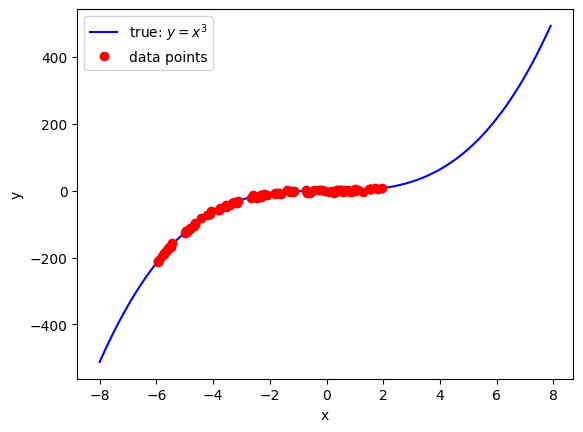

In [17]:
plot_data(x_tr,y_tr)

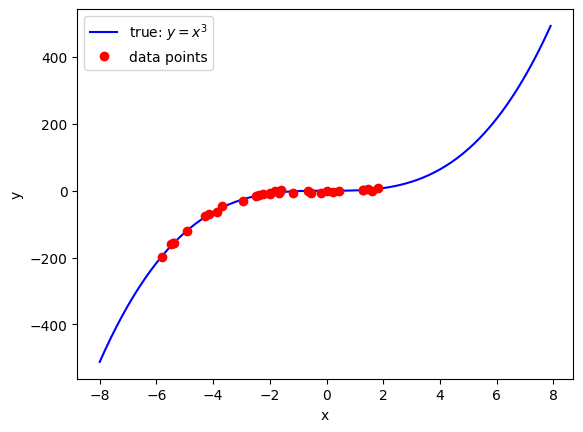

In [11]:
plot_data(x_val,y_val)

In [169]:
np.random.seed(7)
sig = 3

n = 100
#np.random.random(size=n) Return random floats in the half-open interval [0.0, 1.0).
x_data = 8 * np.random.random(size=n) - 6
#e = sig * np.random.randn(n)

yfun = lambda x: x**3 + sig * np.random.randn()  #np.random.randn() Return a sample (or samples) from the “standard normal” distribution.
y_data = np.array(list(map(yfun, x_data)))

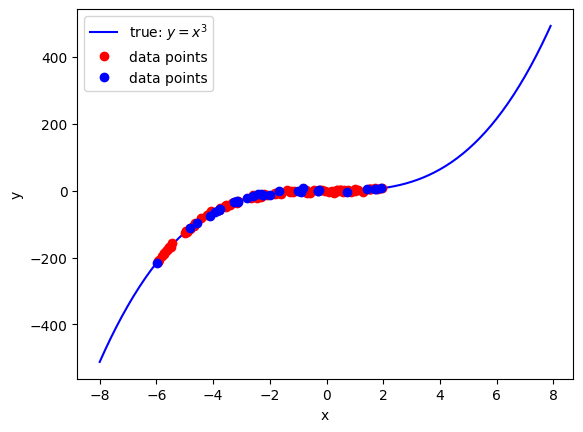

In [19]:
# _x and -y are true measure without the noise  e
# x_data and y_data are 20 mesuremnets sample that may have certain noise
_x = np.arange(-8, 8, 0.1)
_y = list(map(lambda x: x*x*x, _x))
plt.plot(_x, _y, 'b-', label='true: $y=x^3$')
plt.plot(x_tr, y_tr, 'ro', label='data points')
#plt.plot(x_val, y_val, 'go', label='data points')
plt.plot(x_test, y_test, 'bo', label='data points')

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [172]:
def normalize_data(x):
    mu = np.mean(x)
    std = np.std(x)
    return (x-mu)/std, mu, std

In [173]:
x_data_norm, x_mu, x_std = normalize_data(x_data)
y_data_norm, y_mu, y_std = normalize_data(y_data)

In [174]:
dataset = tf.data.Dataset.from_tensor_slices({
    'x': np.array(x_data_norm).astype(np.float32),
    'y': np.array(y_data_norm).astype(np.float32)
})

In [175]:
dataset = dataset.shuffle(20).batch(5)

In [176]:
sample=next(iter(dataset))
print(sample['x'].shape,sample['y'].shape)

(5,) (5,)


In [177]:
# gradient function
def grad_mse(model, inputs, outputs,loss_func):
    with tf.GradientTape() as t:
        out = model(inputs)
        current_loss = loss_func(out, outputs)
    grads = t.gradient(current_loss, model.trainable_variables)
    
    return current_loss, grads

In [178]:
def train(model,optimizer,loss_func,grad_func,metrics,epochs=10):
    #adv_grad tells how to combine the gradient. "loss_comb" means add the loss for x and x` and compute gradinet
    # "grad_comb" means compute the gradient for x and x` and then add the gradients
    loss_epoch=[]
    for epoch in range(1, epochs+1):
        for data in dataset:
            x, y = data['x'], data['y']
            x = tf.expand_dims(x, 1)
            y = tf.expand_dims(y, 1)
            with tf.GradientTape() as t:
                t.watch(x)
                loss_val, grads = grad_func(model, x, y,loss_func)
                
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            metrics['train/loss'].update_state(loss_val)
        loss_epoch.append(metrics['train/loss'].result())
        if epoch % 10 == 0:
            print('[{}/{}] loss = {:5f}'.format(epoch, epochs, loss_epoch[-1]))
    return loss_epoch

In [179]:
mlp_mse = MLP() # standard MLP
mlp_optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])
loss_mse = tf.keras.losses.MeanSquaredError()

metrics = {'train/loss': tf.keras.metrics.Mean()}

#mlp.compile(optimizer=mlp_optimizer,loss=loss_mse)
#hist=mlp.fit(np.float(x_data),np.float(y_data),epochs=100)
losses=train(mlp_mse,mlp_optimizer,loss_mse,grad_mse,metrics,epochs=100)
#return mlp_mse,losses

[10/100] loss = 0.069658
[20/100] loss = 0.038698
[30/100] loss = 0.027716
[40/100] loss = 0.022780
[50/100] loss = 0.019483
[60/100] loss = 0.017214
[70/100] loss = 0.015492
[80/100] loss = 0.014208
[90/100] loss = 0.013539
[100/100] loss = 0.012778


In [182]:
def plot_single(model,plot_name='MLP (MSE)'):
    _x = np.arange(-8, 8, 0.1)
    _y = list(map(lambda x: x*x*x, _x))
    plt.plot(_x, _y, 'b-', label='true: $y=x^3$')
    plt.plot(x_data, y_data, 'ro', label="data points")
    out = model.predict((_x - x_mu)/x_std)
    plt.plot(_x, out*y_std+y_mu, label=plot_name, color='grey')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

5/5 [==============================] - 0s 2ms/step


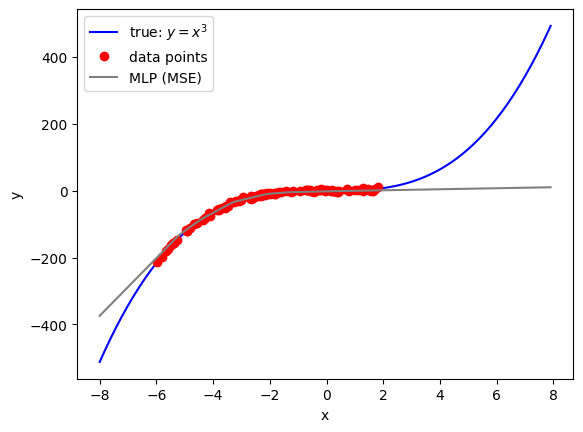

In [183]:
plot_single(mlp_mse,'MLP (MSE)')

In [184]:
y_pred = mlp_mse(x_data)

In [185]:
import pandas as pd
df = pd.DataFrame(y_data)


In [186]:
df

,0
0,-157.138262
1,-1.758597
2,-16.388145
3,3.881090
4,10.656306
...,...
95,-8.563831
96,-1.382903
97,1.138162
98,-111.274748


In [187]:
#quantile_mark = lambda x: df.quantile(x, interpolation="higher")
quantile_mark = lambda x: df.quantile(x)

for m in [0.25,0.5,0.75,1]:
    print(quantile_mark(m).values[0])

-45.33778811668212
-8.518881931207947
0.5985181633987153
10.656305722646952


In [188]:
num_bins=10

bin_size = 1.0 / num_bins
bins = np.linspace(0.0, 1.0, num_bins + 1)
#indices = np.digitize(pred, bins, right=True)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [189]:
bin_accuracies = np.zeros(num_bins, dtype=float)
bin_confidences = np.zeros(num_bins, dtype=float)
bin_counts_pred = np.zeros(num_bins, dtype=int)
bin_counts_gt = np.zeros(num_bins, dtype=int)

In [190]:
percentile_dict = {}
for conf in bins:
    key=np.round(conf,1)
    val=np.round(quantile_mark(conf).values[0],3)
    print(key,val)
    percentile_dict[key]=val

0.0 -213.65
0.1 -116.683
0.2 -54.737
0.3 -28.161
0.4 -15.286
0.5 -8.519
0.6 -3.033
0.7 -0.82
0.8 0.878
0.9 2.913
1.0 10.656


In [191]:
for b in range(num_bins):
    key=np.round(bins[b+1],1)
    percentile_val_high = percentile_dict[key]
    if b==0:
        selected_gt = [x for x in y_data if x <=percentile_val_high]
        selected_pred = [x for x in y_pred if x <=percentile_val_high]

    else:
        key=np.round(bins[b],1)
        percentile_val_low = percentile_dict[key]
        selected_gt = [x for x in y_data if x <=percentile_val_high and x>percentile_val_low]
        selected_pred = [x for x in y_pred if x <=percentile_val_high and x>percentile_val_low]

    #selected = np.where(indices == b + 1)[0]
    if len(selected_pred) > 0:
        bin_accuracies[b] = len(selected_gt)/len(y_pred)
        bin_confidences[b] =  len(selected_pred)/len(y_pred)
        bin_counts_pred[b] = len(selected_pred)
    if len(selected_gt) > 0:
        bin_counts_gt[b] = len(selected_gt)

In [192]:
bin_accuracies

array([0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.1, 0. , 0. ])

In [193]:
bin_confidences

array([0.  , 0.  , 0.  , 0.06, 0.2 , 0.27, 0.09, 0.38, 0.  , 0.  ])

In [194]:
bin_counts_gt

array([10, 10, 10, 10, 10, 10, 10, 10, 10,  9])

In [195]:
bin_counts_pred

array([ 0,  0,  0,  6, 20, 27,  9, 38,  0,  0])

In [196]:
#bin_counts_cdf = [bin_counts_gt[0]]
for i in range(1,len(bin_counts_gt)):
    bin_counts_gt[i] = bin_counts_gt[i]+bin_counts_gt[i-1]

In [198]:
for i in range(1,len(bin_counts_pred)):
    bin_counts_pred[i] = bin_counts_pred[i]+bin_counts_pred[i-1]

In [199]:
bin_counts_gt, bin_counts_pred

(array([10, 20, 30, 40, 50, 60, 70, 80, 90, 99]),
 array([  0,   0,   0,   6,  26,  53,  62, 100, 100, 100]))

In [31]:
#bin_counts_gt = np.array([2,4,6,8,10,12,14,16,18,20])
#bin_counts_pred = np.array([0,0,1,6,13,13,14,19,20,20])

In [32]:
# avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
# avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

# gaps = np.abs(bin_accuracies - bin_confidences)
# ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
# mce = np.max(gaps)

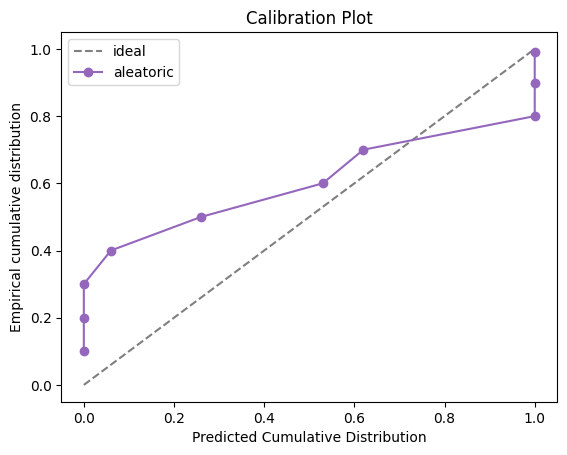

In [200]:
plt.figure()
plt.plot([0,1], [0,1], '--', color='tab:gray', label = 'ideal')
plt.plot(bin_counts_pred/n,bin_counts_gt/n, '-o', color='tab:purple', label='aleatoric')
plt.xlabel('Predicted Cumulative Distribution')
plt.ylabel('Empirical cumulative distribution')
plt.legend()
plt.title('Calibration Plot')
plt.show()

In [201]:
def nll(mean_values, var_values, y):
    y_diff = tf.math.subtract(y, mean_values)
    return 0.5*tf.reduce_mean(tf.math.log(var_values)) \
            + 0.5*tf.reduce_mean(tf.divide(tf.square(y_diff), var_values)) \
            + 0.5*tf.math.log(2*np.pi)

In [202]:
# gradient function
def grad_gaussian(model, inputs, outputs,loss_func):
    with tf.GradientTape() as t:
        mean_values, var_values = model(inputs)
        current_loss = loss_func(mean_values, var_values, outputs)
    grads = t.gradient(current_loss, model.trainable_variables)
    
    return current_loss, grads

In [204]:
#def train_mlp_gaussian(config,adv_train=False,total_grads="loss_comb",epochs=200):

mlp_gauss = GaussianMLP() # standard MLP
mlp_optimizer = tf.keras.optimizers.Adam(learning_rate=config["lr"])

metrics = {'train/loss': tf.keras.metrics.Mean()}

#mlp.compile(optimizer=mlp_optimizer,loss=loss_mse)
#hist=mlp.fit(np.float(x_data),np.float(y_data),epochs=100)
#losses=train(mlp,e_adv_xnorm,mlp_optimizer,nll,grad_gaussian,metrics,adv_train=adv_train,total_grads=total_grads,epochs=epochs)
losses=train(mlp_gauss,mlp_optimizer,nll,grad_gaussian,metrics,epochs=200)

#return mlp,losses

[10/200] loss = -0.208038
[20/200] loss = -0.592325
[30/200] loss = -0.762800
[40/200] loss = -0.870904
[50/200] loss = -0.921540
[60/200] loss = -0.958566
[70/200] loss = -0.977992
[80/200] loss = -1.014454
[90/200] loss = -1.035290
[100/200] loss = -1.039755
[110/200] loss = -1.003808
[120/200] loss = -1.022498
[130/200] loss = -1.033631
[140/200] loss = -1.050126
[150/200] loss = -1.068960
[160/200] loss = -1.079483
[170/200] loss = -1.090407
[180/200] loss = -1.102754
[190/200] loss = -1.114003
[200/200] loss = -1.124671


In [205]:
def plot_single(mlp_gauss,plot_name="'MLP_Gauss (NLL)'"):
    _x = np.arange(-8, 8, 0.1)
    _y = list(map(lambda x: x*x*x, _x))
    plt.plot(_x, _y, 'b-', label='true')
    plt.plot(x_data, y_data, 'ro', label='measure')


    mu,var = mlp_gauss.predict((_x - x_mu)/x_std)

    upper_y = np.squeeze((mu + 3*np.sqrt(var))*y_std + y_mu)
    lower_y = np.squeeze((mu - 3*np.sqrt(var))*y_std + y_mu)

    plt.plot(_x, mu*y_std+y_mu, label='mean: '+plot_name, color='grey')
    plt.fill_between(_x, lower_y, upper_y, color='gray', alpha=0.3, label='3*std: '+plot_name)
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.show()

5/5 [==============================] - 0s 0s/step


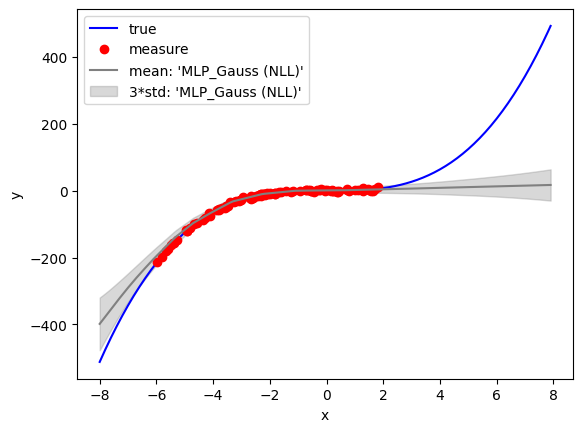

In [206]:
plot_single(mlp_gauss,plot_name="'MLP_Gauss (NLL)'")

4/4 [==============================] - 0s 1ms/step


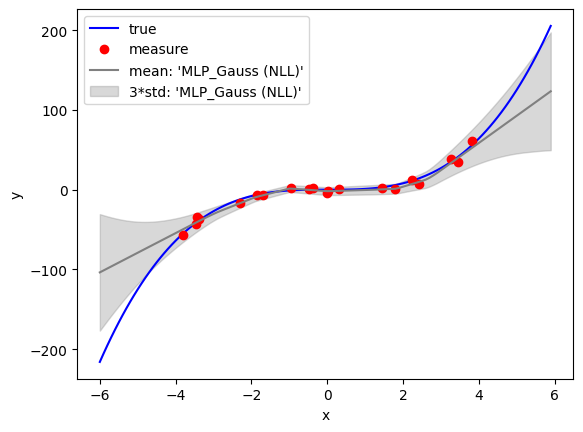

In [110]:
plot_single(mlp_gauss,plot_name="'MLP_Gauss (NLL)'")

In [207]:
y_pred_mu,y_pred_var = mlp_gauss(x_data)
y_pred_sigma = np.sqrt(y_pred_var)

In [208]:
n_intervals = 100
p_m = np.linspace(0,1,n_intervals)
emp_conf = [0]*n_intervals
for i in range(n_intervals):
    interval_fit = np.less_equal(np.abs(y_pred_mu[:,0]-y_data), np.abs(y_pred_sigma[:,0]*stats.norm.ppf((1-p_m[i])/2)))
    emp_conf[i] = np.mean(interval_fit,axis=0)

In [209]:
emp_conf

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.01,
 0.02,
 0.02,
 0.02,
 0.02,
 0.02,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.03,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 0.04,
 1.0]

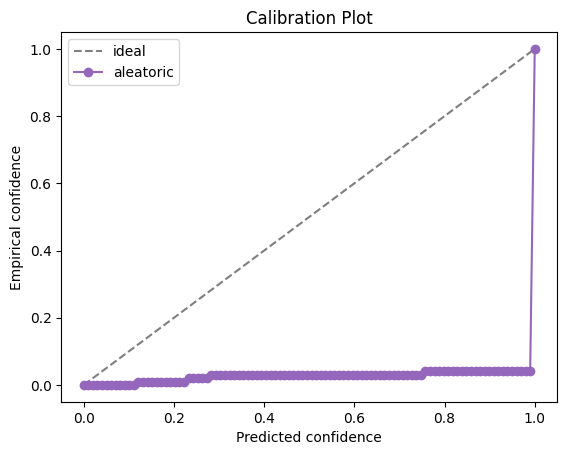

In [210]:
plt.figure()
plt.plot([0,1], [0,1], '--', color='tab:gray', label = 'ideal')
plt.plot(p_m, emp_conf, '-o', color='tab:purple', label='aleatoric')
plt.xlabel('Predicted confidence')
plt.ylabel('Empirical confidence')
plt.legend()
plt.title('Calibration Plot')
plt.show()

In [211]:
from sklearn.isotonic import IsotonicRegression

isotonic = IsotonicRegression(out_of_bounds='clip')
isotonic.fit(emp_conf,p_m)

IsotonicRegression(out_of_bounds='clip')

In [220]:
y_pred_sigma_cal = isotonic.predict(y_pred_sigma)

In [222]:
emp_conf_cl = [0]*n_intervals
for i in range(n_intervals):
    interval_fit = np.less_equal(np.abs(y_pred_mu[:,0]-y_data), np.abs(y_pred_sigma_cal*stats.norm.ppf((1-p_m[i])/2)))
    emp_conf_cl[i] = np.mean(interval_fit,axis=0)

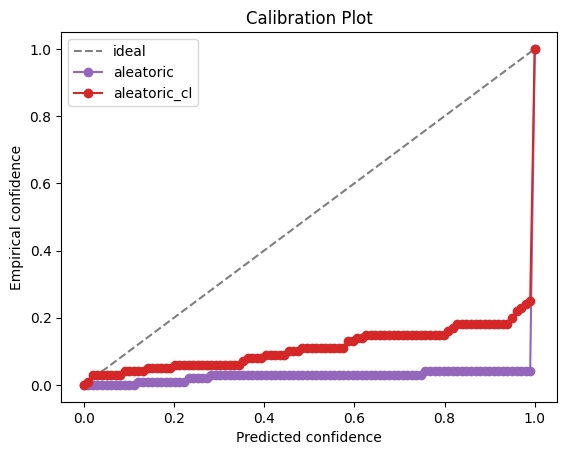

In [223]:
plt.figure()
plt.plot([0,1], [0,1], '--', color='tab:gray', label = 'ideal')
plt.plot(p_m, emp_conf, '-o', color='tab:purple', label='aleatoric')
plt.plot(p_m, emp_conf_cl, '-o', color='tab:red', label='aleatoric_cl')

plt.xlabel('Predicted confidence')
plt.ylabel('Empirical confidence')
plt.legend()
plt.title('Calibration Plot')
plt.show()

In [213]:
conf_level_lower_bounds = np.arange(start=0.025, stop=0.5, step=0.025)
conf_levels = 1-2*conf_level_lower_bounds

unc_pcts = []
cal_pcts = []
for cl_lower in conf_level_lower_bounds:
    quants = [cl_lower, 1-cl_lower]
    print(quants)
    #post_pred_test, new_quantiles = self.predict(X_test, y_test, quants)
    new_quantiles = isotonic.transform(quants)
    cal_lower, cal_upper = np.quantile(y_pred, new_quantiles) #, axis=1)
    unc_lower, unc_upper = np.quantile(y_pred, quants)
    print(unc_lower, unc_upper)
    print(cal_lower, cal_upper)
    perc_within_unc = np.mean((y_data <= unc_upper)&(y_data >= unc_lower))
    perc_within_cal = np.mean((y_data <= cal_upper)&(y_data >= cal_lower))

    unc_pcts.append(perc_within_unc)
    cal_pcts.append(perc_within_cal)

[0.025, 0.975]
-16.007872581481934 0.6372580662369728
-5.1683120727539045 0.6479546860791743
[0.05, 0.95]
-15.315887117385865 0.6303443878889083
0.5813466397424539 0.6457624109461905
[0.07500000000000001, 0.925]
-14.297887444496155 0.6146729528903961
0.5825336879740158 0.6435701358132064
[0.1, 0.9]
-13.535694885253907 0.6040859997272492
0.5867162104696035 0.641944820061326
[0.125, 0.875]
-12.585138320922852 0.5813276469707489
0.5913702428030471 0.6403634925372899
[0.15, 0.85]
-11.458673095703125 0.5568992733955381
0.5960242751364905 0.6387821650132537
[0.17500000000000002, 0.825]
-10.528541088104246 0.5485899955034256
0.5985625265166163 0.6377939633093774
[0.2, 0.8]
-9.6892822265625 0.5302718997001648
0.6005451182524363 0.6369055397808552
[0.225, 0.775]
-8.965086984634398 0.49833537787199056
0.6025277099882563 0.6360171162523329
[0.25, 0.75]
-8.68904995918274 0.45054303109645844
0.6054340014234185 0.6351622951527436
[0.275, 0.725]
-7.774955928325653 0.32471114993095385
0.60869950940832

In [214]:
y_pred,isotonic.predict(y_pred)

(<tf.Tensor: shape=(100, 1), dtype=float32, numpy=
 array([[-1.5190415e+01],
        [ 5.3319138e-01],
        [-5.1683121e+00],
        [ 3.5562429e-01],
        [ 6.5014696e-01],
        [-2.3550911e+00],
        [-3.4051213e+00],
        [-1.5307480e+01],
        [-9.9101610e+00],
        [-3.4399014e+00],
        [ 5.8964431e-02],
        [ 5.5341494e-01],
        [-6.7859116e+00],
        [-1.5475625e+01],
        [-9.3668442e+00],
        [ 6.1477661e-01],
        [-1.1423491e+01],
        [-4.7823434e+00],
        [ 6.2610763e-01],
        [-1.6604061e+01],
        [-1.0144422e+00],
        [ 6.3582522e-01],
        [-1.0958651e+01],
        [-2.0757601e+00],
        [ 6.1453271e-01],
        [-1.3627335e+01],
        [-2.7788429e+00],
        [ 4.7003758e-01],
        [-1.2524575e-02],
        [-4.3425555e+00],
        [-1.1658041e+01],
        [-3.6960244e+00],
        [-7.0265923e+00],
        [-4.0714951e+00],
        [-7.2089939e+00],
        [ 5.7664382e-01],
        [ 5.0

Expected Calibration Error ece uncalibrated=-0.27894736842105256
Expected Calibration Error ece calibrated=-0.48052631578947363


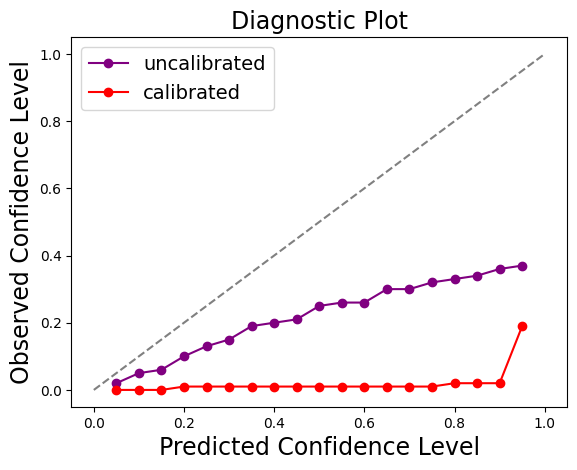

In [215]:
fig,ax=plt.subplots(1,1)
ax.plot([0,1],[0,1],'--', color='grey')
ax.plot(conf_levels, unc_pcts, '-o', color='purple', label='uncalibrated')
ax.plot(conf_levels, cal_pcts, '-o', color='red', label='calibrated')
ax.legend(fontsize=14)
ax.set_title('Diagnostic Plot', fontsize=17)
ax.set_xlabel('Predicted Confidence Level', fontsize=17)
ax.set_ylabel('Observed Confidence Level', fontsize=17)
ece_unc = np.mean((unc_pcts-conf_levels))
ece_cal = np.mean((cal_pcts-conf_levels))

print("Expected Calibration Error ece uncalibrated={}".format(ece_unc))
print("Expected Calibration Error ece calibrated={}".format(ece_cal))

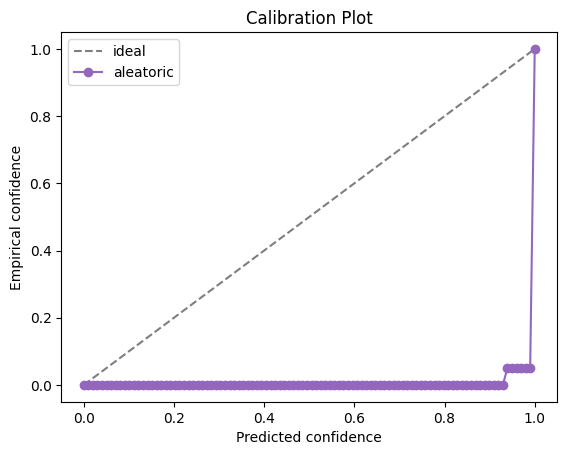

In [107]:
plt.figure()
plt.plot([0,1], [0,1], '--', color='tab:gray', label = 'ideal')
plt.plot(p_m, emp_conf, '-o', color='tab:purple', label='aleatoric')
plt.xlabel('Predicted confidence')
plt.ylabel('Empirical confidence')
plt.legend()
plt.title('Calibration Plot')
plt.show()

In [90]:
 np.abs(y_pred_sigma*stats.norm.ppf((1-p_m[10])/2))

array([[0.2264003 ],
       [0.07866342],
       [0.00790476],
       [0.04316002],
       [0.25249693],
       [0.00939026],
       [0.00856578],
       [0.23022306],
       [0.04629514],
       [0.00854332],
       [0.02605207],
       [0.09840957],
       [0.01124794],
       [0.23563232],
       [0.03620959],
       [0.19715643],
       [0.08766346],
       [0.00781627],
       [0.21574299],
       [0.2696192 ]], dtype=float32)

In [153]:
std_normal = tfp.distributions.Normal(loc=0, scale=1)
alpha = np.arange(start=1, stop=0, step=-0.01)
confidence_level = 1-alpha
std_quantile_multiplier = std_normal.quantile(alpha/2)*(-1)

In [152]:
#confidence_level

In [154]:
#p_m

In [155]:
#std_quantile_multiplier

In [156]:
conf=[]
for a in alpha:
    std_quantile_multiplier = std_normal.quantile(a/2)*(-1)
    t_predicted_residual = y_pred_sigma[:,0]*std_quantile_multiplier
    t_residual = tf.math.abs(y_pred_mu[:,0]-y_data)
    t_interval_fit = tf.math.less_equal(t_residual, t_predicted_residual)
    conf.append(np.mean(t_interval_fit))



In [157]:
conf


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05,
 0.05]

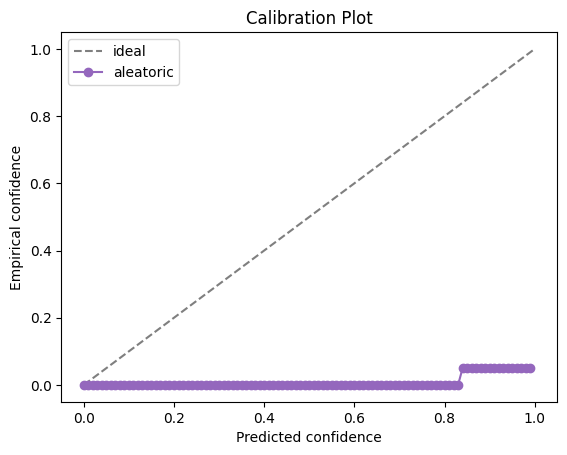

In [158]:
plt.figure()
plt.plot([0,1], [0,1], '--', color='tab:gray', label = 'ideal')
plt.plot(confidence_level, conf, '-o', color='tab:purple', label='aleatoric')
plt.xlabel('Predicted confidence')
plt.ylabel('Empirical confidence')
plt.legend()
plt.title('Calibration Plot')
plt.show()

In [131]:
y_pred_sigma

array([[1.9651387 ],
       [0.66417956],
       [0.05536018],
       [0.349104  ],
       [2.043639  ],
       [0.06594507],
       [0.05977489],
       [1.9968622 ],
       [0.3617244 ],
       [0.0595868 ],
       [0.20164064],
       [0.8327629 ],
       [0.07691196],
       [2.0416925 ],
       [0.2722216 ],
       [1.6203946 ],
       [0.745061  ],
       [0.05368711],
       [1.7619785 ],
       [2.3183272 ]], dtype=float32)

In [132]:
t_predicted_residual = y_pred_sigma*std_quantile_multiplier
t_predicted_residual

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[-0.00000000e+00,  1.23227552e-01,  2.46942028e-01,
         3.71643841e-01,  4.97862190e-01,  6.26170516e-01,
         7.57208169e-01,  8.91705692e-01,  1.03051960e+00,
         1.17468143e+00,  1.32546604e+00,  1.48449528e+00,
         1.65390241e+00,  1.83659756e+00,  2.03673553e+00,
         2.26059628e+00,  2.51842666e+00,  2.82887864e+00,
         3.23236537e+00,  3.85160089e+00],
       [-0.00000000e+00,  4.16485742e-02,  8.34617168e-02,
         1.25608563e-01,  1.68267965e-01,  2.11633757e-01,
         2.55921990e-01,  3.01379591e-01,  3.48296076e-01,
         3.97020042e-01,  4.47982341e-01,  5.01731217e-01,
         5.58987617e-01,  6.20735109e-01,  6.88377917e-01,
         7.64038622e-01,  8.51180375e-01,  9.56107259e-01,
         1.09247816e+00,  1.30176795e+00],
       [-0.00000000e+00,  3.47145926e-03,  6.95663551e-03,
         1.04696266e-02,  1.40253399e-02,  1.76399313e-02,
         2.13314090e-02,  2.51203571e-

In [128]:
t_residual = tf.math.abs(y_pred_sigma[:,0]-y_data)
t_residual

<tf.Tensor: shape=(20,), dtype=float64, numpy=
array([39.24354213, 10.93711075,  0.64839601,  0.78478692, 58.82303965,
        0.42627024,  1.221194  , 36.03746883,  6.85508905,  4.4116229 ,
        1.53050317,  6.64964508,  2.20719522, 45.16374398,  7.36823931,
       36.77972003, 17.75322905,  1.49641541, 33.09583995, 59.21173632])>

In [129]:
t_interval_fit = tf.math.less_equal(t_residual, t_predicted_residual)
t_interval_fit

InvalidArgumentError: cannot compute LessEqual as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:LessEqual]

In [ ]:

t_interval_fit = tf.math.less_equal(t_residual, t_predicted_residual)
t_confidence_per_interval=tf.math.count_nonzero(t_interval_fit, axis=[0,1,2])/(input_wh*input_wh*image.shape[0])
np_data.append(t_confidence_per_interval)

In [97]:
#y_pred_mu[:,0].shape, y_data.shape

In [98]:
#np.abs(y_pred_mu-y_data)

In [99]:
y_pred_sigma.shape

(20, 1)

In [102]:
stats.norm.ppf((1-p_m[10])/2)

-0.12693745830564301

In [104]:
np.mean(np.less_equal(np.abs(y_pred_mu[:,0]-y_data), np.abs(y_pred_sigma[:,0]*stats.norm.ppf((1-p_m[10])/2))),axis=0)

0.0

In [51]:
std_normal = tfp.distributions.Normal(loc=0, scale=1)
#std_normal.ppf(2)

AttributeError: 'Normal' object has no attribute 'ppf'

In [53]:
import scipy.stats as stats

In [ ]:
sigma=2

In [62]:
sigma*stats.norm.ppf(0.25)

-1.3489795003921634

In [64]:
stats.norm.ppf(0.25,loc=0,scale=sigma)

-1.3489795003921634

In [57]:
sigma = 2

In [49]:
#y_pred_mu

In [50]:
a3y_pred_var

NameError: name 'a3y_pred_var' is not defined

In [42]:
import tensorflow_probability as tfp

In [119]:
std_normal = tfp.distributions.Normal(loc=0, scale=1)
alpha = np.arange(start=1, stop=0, step=-0.05)
confidence_level = 1-alpha
std_quantile_multiplier = std_normal.quantile(alpha/2)*(-1)



In [44]:
alpha, confidence_level, std_quantile_multiplier

(array([1.  , 0.95, 0.9 , 0.85, 0.8 , 0.75, 0.7 , 0.65, 0.6 , 0.55, 0.5 ,
        0.45, 0.4 , 0.35, 0.3 , 0.25, 0.2 , 0.15, 0.1 , 0.05]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
 <tf.Tensor: shape=(20,), dtype=float32, numpy=
 array([-0.        ,  0.0627068 ,  0.12566137,  0.18911839,  0.2533471 ,
         0.31863937,  0.38532048,  0.45376223,  0.5244005 ,  0.5977601 ,
         0.6744898 ,  0.755415  ,  0.8416212 ,  0.93458927,  1.0364335 ,
         1.1503495 ,  1.2815516 ,  1.4395313 ,  1.6448536 ,  1.9599639 ],
       dtype=float32)>)

In [68]:
0.95/2

0.475

In [69]:
stats.norm.ppf(0.475)

-0.06270677794321385

In [72]:
stats.norm.ppf(0.95)+stats.norm.ppf(0.25)

0.9703638767553905

In [102]:
 std_normal.quantile(alpha/2)*-1

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.        ,  0.0627068 ,  0.12566137,  0.18911839,  0.2533471 ,
        0.31863937,  0.38532048,  0.45376223,  0.5244005 ,  0.5977601 ,
        0.6744898 ,  0.755415  ,  0.8416212 ,  0.93458927,  1.0364335 ,
        1.1503495 ,  1.2815516 ,  1.4395313 ,  1.6448536 ,  1.9599639 ],
      dtype=float32)>

In [120]:
#reconstruction = y_pred_mu
#reconstr_var   = y_pred_var

t_predicted_residual = y_pred_sigma[:,0]*std_quantile_multiplier
t_residual = tf.math.abs(y_pred_mu[:,0]-y_data)
t_interval_fit = tf.math.less_equal(t_residual, t_predicted_residual)


In [121]:
t_predicted_residual

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([-0.        ,  0.04164857,  0.00695664,  0.06602198,  0.51775   ,
        0.0210127 ,  0.02303249,  0.90610063,  0.18968844,  0.03561861,
        0.13600455,  0.6290816 ,  0.06473073,  1.9081439 ,  0.28213957,
        1.8640201 ,  0.9548341 ,  0.07728428,  2.8981967 ,  4.5438375 ],
      dtype=float32)>

In [122]:
t_residual

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([31.407211  ,  7.7817974 ,  0.7158618 ,  1.3106136 , 52.18976   ,
        0.4440793 ,  1.1954374 , 28.094147  ,  4.0077033 ,  4.3890066 ,
        0.36504686,  3.081658  ,  2.9240336 , 37.067482  ,  4.9559717 ,
       31.40577   , 13.554964  ,  1.4438403 , 27.332348  , 50.110535  ],
      dtype=float32)>

In [123]:
t_interval_fit

<tf.Tensor: shape=(20,), dtype=bool, numpy=
array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False])>

In [124]:
t_confidence_per_interval=tf.math.count_nonzero(t_interval_fit, axis=0)


In [125]:
t_confidence_per_interval

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [114]:
t_confidence_per_interval=tf.math.count_nonzero(t_interval_fit, axis=[0,1,2])/(input_wh*input_wh*image.shape[0])
#np_data.append(t_confidence_per_interval)

InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:CPU:0}} Invalid reduction dimension (2 for input with 2 dimension(s) [Op:Sum]

In [ ]:
reconstruction =y_pred_mu
reconstr_var   = tf.math.exp(y_pred_var)

t_predicted_residual = reconstr_var*std_quantile_multiplier
t_residual = tf.math.abs(reconstruction-y_data)
t_interval_fit = tf.math.less_equal(t_residual, t_predicted_residual)

In [121]:
t_predicted_residual

<tf.Tensor: shape=(20, 20), dtype=float32, numpy=
array([[-0.00000000e+00,  2.45063996e+00,  4.91096306e+00,
         7.39092207e+00,  9.90104008e+00,  1.24527225e+01,
         1.50586824e+01,  1.77334499e+01,  2.04940567e+01,
         2.33610191e+01,  2.63596878e+01,  2.95223198e+01,
         3.28913383e+01,  3.65246162e+01,  4.05047836e+01,
         4.49567261e+01,  5.00842285e+01,  5.62582207e+01,
         6.42824097e+01,  7.65972137e+01],
       [-0.00000000e+00,  1.04821742e-01,  2.10057676e-01,
         3.16133499e-01,  4.23499286e-01,  5.32642961e-01,
         6.44108236e-01,  7.58516610e-01,  8.76596689e-01,
         9.99225855e-01,  1.12748849e+00,  1.26276457e+00,
         1.40686822e+00,  1.56227517e+00,  1.73251975e+00,
         1.92294371e+00,  2.14226341e+00,  2.40634489e+00,
         2.74956512e+00,  3.27630877e+00],
       [-0.00000000e+00,  6.30300567e-02,  1.26309171e-01,
         1.90093309e-01,  2.54653126e-01,  3.20281982e-01,
         3.87306839e-01,  4.56101418e-

In [116]:
n_intervals = 100
p_m = np.linspace(0,1,n_intervals)
emp_conf = [0]*n_intervals
for i in range(n_intervals):
    interval_fit = np.less_equal(np.abs(y_pred_mu-y_data),t_predicted_residual)
    emp_conf[i] = np.mean(interval_fit,axis=0)

In [117]:
emp_conf[i]

array([0.  , 0.05, 0.15, 0.25, 0.  , 0.3 , 0.3 , 0.05, 0.25, 0.35, 0.45,
       0.35, 0.45, 0.2 , 0.35, 0.25, 0.3 , 0.7 , 0.3 , 0.25])

In [120]:
len(emp_conf)

100

In [118]:
p_m 

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [107]:
y_pred_mu, y_data

(<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
 array([[-5.4508853 ],
        [ 3.7182336 ],
        [ 0.05139887],
        [ 2.4122658 ],
        [ 8.305722  ],
        [ 0.06007683],
        [ 0.10221572],
        [-5.520369  ],
        [-2.3172717 ],
        [ 0.10361144],
        [ 1.4050654 ],
        [ 4.269282  ],
        [-0.5359514 ],
        [-5.6201725 ],
        [-1.9967948 ],
        [ 6.720168  ],
        [-3.213558  ],
        [ 0.13919345],
        [ 7.221165  ],
        [-6.289968  ]], dtype=float32)>,
 array([-37.27840346,  11.60129032,   0.70375618,   1.1338909 ,
         60.8666786 ,   0.49221532,  -1.16141911, -34.04060666,
         -6.49336464,  -4.3520361 ,   1.73214381,   7.48240797,
          2.28410718, -43.12205149,  -7.09601771,  38.40011462,
        -17.00816807,   1.55010253,  34.85781846, -56.89340913]))

In [ ]:
    np_data = []
    sparsification_data =[]
    info_sparse_plot = {"quantile_ids": [], "quantile_counts":[]}
    cnt_batch = 0

In [ ]:
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten
 
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
x_train = train_images.reshape(60000, 28, 28, 1) / 255
x_test = test_images.reshape(10000, 28, 28, 1) / 255
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
 
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
 
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=50)


Epoch 1/10
1200/1200 [==============================] - 19s 15ms/step - loss: 0.1442 - accuracy: 0.9573 - val_loss: 0.0498 - val_accuracy: 0.9836
Epoch 2/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0447 - accuracy: 0.9859 - val_loss: 0.0373 - val_accuracy: 0.9867
Epoch 3/10
1200/1200 [==============================] - 17s 14ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0452 - val_accuracy: 0.9855
Epoch 4/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0228 - accuracy: 0.9924 - val_loss: 0.0305 - val_accuracy: 0.9897
Epoch 5/10
1200/1200 [==============================] - 15s 13ms/step - loss: 0.0161 - accuracy: 0.9947 - val_loss: 0.0314 - val_accuracy: 0.9895
Epoch 6/10
1200/1200 [==============================] - 16s 13ms/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.0454 - val_accuracy: 0.9854
Epoch 7/10
1200/1200 [==============================] - 17s 14ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0334 -

In [ ]:
hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=50)


In [57]:
pred_prob =  model.predict(x_test)

313/313 [==============================] - 2s 6ms/step


In [58]:
pred_prob.shape

(10000, 10)

In [59]:
pred_prob[0:5]

array([[6.8426077e-21, 5.6827881e-15, 1.2304005e-16, 5.0389717e-24,
        2.4703848e-21, 1.8833581e-23, 6.6268716e-29, 1.0000000e+00,
        5.0399185e-22, 1.3354221e-19],
       [1.5393574e-13, 9.4745804e-13, 1.0000000e+00, 8.5189515e-20,
        2.9868347e-25, 3.3163344e-30, 2.7004766e-13, 9.9695418e-21,
        2.3680935e-19, 1.4827376e-23],
       [2.1996936e-16, 1.0000000e+00, 4.3806939e-15, 2.8016966e-20,
        3.8092867e-12, 3.9959206e-13, 3.1727912e-11, 2.9161704e-10,
        6.3705305e-11, 2.2690359e-15],
       [1.0000000e+00, 1.8026317e-17, 6.0468605e-12, 2.3106086e-19,
        7.9882011e-21, 1.7880662e-15, 1.1154127e-11, 6.6850339e-16,
        2.3725560e-15, 1.8127343e-13],
       [8.7793648e-17, 4.9723312e-16, 2.0916657e-15, 1.6702088e-19,
        9.9999988e-01, 8.2358178e-17, 1.8467204e-14, 5.0111171e-17,
        6.2959665e-10, 7.6423589e-08]], dtype=float32)

In [60]:
confidences=np.max(pred_prob,axis=1)
confidences[0:5]

array([1.       , 1.       , 1.       , 1.       , 0.9999999],
      dtype=float32)

In [61]:
np.argmax(pred_prob[0:10],axis=1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [62]:
test_labels

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [63]:
import numpy as np
pred_labels = np.argmax(pred_prob,axis=1)

In [64]:
pred_label.shape

(10000,)

In [65]:
scores = compute_calibration(test_labels, pred_labels, confidences, num_bins=10)

C:\Users\uid38717\AppData\Local\Temp\ipykernel_8228\2767785863.py:31: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\uid38717\AppData\Local\Temp\ipykernel_8228\2767785863.py:32: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

C:\Users\uid38717\AppData\Local\Temp\ipykernel_8228\2767785863.py:33: DeprecationWarning:

`np.int` is a dep

In [66]:
scores

{'accuracies': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.4375    , 0.5       , 0.56521739, 0.46153846, 0.99516422]),
 'confidences': array([0.        , 0.        , 0.        , 0.        , 0.47580668,
        0.54877436, 0.64885032, 0.75892317, 0.85337895, 0.99966729]),
 'counts': array([   0,    0,    0,    0,    1,   16,    8,   23,   26, 9926]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.9914,
 'avg_confidence': 0.9976787574261426,
 'expected_calibration_error': 0.006278757426142701,
 'max_calibration_error': 0.47580668330192566}

In [71]:
import os
plot_single_calibration_curves(scores,confidences,calib_curve_name="reliability_diagram",hist_name="histogram")

[0.         0.         0.         0.         0.47580668 0.54877436
 0.64885032 0.75892317 0.85337895 0.99966729]
[0.         0.         0.         0.         0.         0.4375
 0.5        0.56521739 0.46153846 0.99516422]


In [37]:
    true_labels = test_labels
    num_bins = 10
    assert len(confidences) == len(pred_labels)
    assert len(confidences) == len(true_labels)
    assert num_bins > 0

In [38]:
    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

In [40]:
bin_size, bins

(0.1, array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [47]:
indices[0:20], confidences[0:20]

(array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
        10,  6, 10], dtype=int64),
 array([1.        , 1.        , 1.        , 1.        , 0.9999087 ,
        1.        , 0.9999982 , 1.        , 0.99884367, 0.999982  ,
        1.        , 1.        , 0.9999963 , 1.        , 1.        ,
        1.        , 1.        , 1.        , 0.56444937, 1.        ],
       dtype=float32))

In [52]:
b=5
selected = np.where(indices == b + 1)[0]

In [53]:
selected

array([  18,  448,  726, 1033, 1299, 1393, 1681, 1717, 1982, 2720, 3005,
       3060, 3129, 3225, 3236, 4007, 4699, 4860, 5331, 5600, 5634, 6651,
       9015, 9158, 9642, 9839], dtype=int64)

In [2]:
#! pip install uncertainty_toolbox

In [3]:
import uncertainty_toolbox.viz as uvi

In [4]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    function taken from : https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert len(confidences) == len(pred_labels)
    assert len(confidences) == len(true_labels)
    assert num_bins > 0

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=np.float)
    bin_confidences = np.zeros(num_bins, dtype=np.float)
    bin_counts = np.zeros(num_bins, dtype=np.int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return {
        "accuracies": bin_accuracies,
        "confidences": bin_confidences,
        "counts": bin_counts,
        "bins": bins,
        "avg_accuracy": avg_acc,
        "avg_confidence": avg_conf,
        "expected_calibration_error": ece,
        "max_calibration_error": mce,
    }

In [111]:
def plot_single_calibration_curves(scores,confidences,calib_curve_name="reliability_diagram",hist_name="histogram"):
    fig_1 = go.Figure()
    fig_2 = go.Figure()
    
    print(scores["confidences"])
    print(scores["accuracies"])


    fig1_trace1=go.Scattergl(x = [0,1], y = [0,1], name = 'perfectly_calibrated', mode = 'lines+markers')
    fig1_trace2=go.Scattergl(x = scores["confidences"], y = scores["accuracies"], name = "not calibrated", mode = 'lines+markers')
    fig_1.add_trace(fig1_trace1)

    fig_1.add_trace(fig1_trace2)

    fig_1.update_layout(
            title="Calibration Curve",
            xaxis_title="Predicted_confidence",
            yaxis_title="Expected_accuracy"
        )        
    #filename=os.path.join(exp_name,'{}.html'.format(calib_curve_name))
    #plotly.offline.plot(fig_1, filename = filename)
    fig_1.show()

    bin_start=scores["bins"][0]
    bin_end=scores["bins"][-1]
    bin_width=0.1 #scores["bins"][1]-scores["bins"][0]
    bin_prop={"start":bin_start,"end":bin_end,"size":bin_width}
   
    counts = scores["counts"]
    bins = scores["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0
    #positions=np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    fig2_trace1=go.Histogram(x=confidences,opacity=0.8,name='confidence histogram', nbinsx=10)  #xbins=bin_prop) #nbinsx=10)
   
    fig2_trace1 = go.Bar(x = positions,y = counts)
    #fig = go.Figure(data=data)
    fig_2.add_trace(fig2_trace1)

    fig2_trace2=go.Scatter(x=[scores["avg_confidence"],scores["avg_confidence"]], y=[0,max(scores['counts'])+2], 
                             mode='lines', 
                             line=dict(color='green', width=5, dash='dash'),
                             name='avg conf: {}'.format(np.round(scores["avg_confidence"],3)))
    fig2_trace3=go.Scatter(x=[scores["avg_accuracy"],scores["avg_accuracy"]], y=[0,max(scores['counts'])+2], 
                             mode='lines', 
                             line=dict(color='black', width=5, dash='solid'),
                             name='avg acc: {}'.format(scores["avg_accuracy"]))
    fig_2.add_trace(fig2_trace2)
    fig_2.add_trace(fig2_trace3)

    fig_2.update_layout(title="Histogram",xaxis_title="predicted_confidence",yaxis_title="num_samples",)

    #filename2=os.path.join(exp_name,'{}.html'.format(hist_name))
    #plotly.offline.plot(fig_2, filename = filename2)
    fig_2.show()

In [108]:
positions=np.array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])
positions=np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [112]:
plot_single_calibration_curves(scores,confidences,calib_curve_name="reliability_diagram",hist_name="histogram")

[0.         0.         0.         0.         0.47580668 0.54877436
 0.64885032 0.75892317 0.85337895 0.99966729]
[0.         0.         0.         0.         0.         0.4375
 0.5        0.56521739 0.46153846 0.99516422]


In [83]:
bin_size*0.9

0.09000000000000001

In [88]:
scores

{'accuracies': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.4375    , 0.5       , 0.56521739, 0.46153846, 0.99516422]),
 'confidences': array([0.        , 0.        , 0.        , 0.        , 0.47580668,
        0.54877436, 0.64885032, 0.75892317, 0.85337895, 0.99966729]),
 'counts': array([   0,    0,    0,    0,    1,   16,    8,   23,   26, 9926]),
 'bins': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 'avg_accuracy': 0.9914,
 'avg_confidence': 0.9976787574261426,
 'expected_calibration_error': 0.006278757426142701,
 'max_calibration_error': 0.47580668330192566}

In [89]:
positions

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [93]:
import matplotlib.pyplot as plt

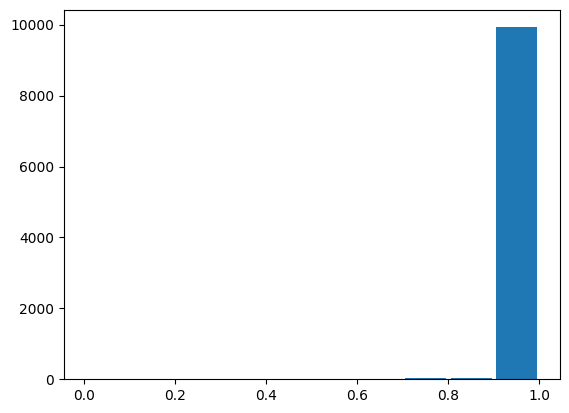

In [95]:
    counts = scores["counts"]
    bins = scores["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    fig = plt.bar(positions, counts,width=bin_size * 0.9)
    #fig.show()

In [97]:
    fig = px.bar(positions, counts) #,width=bin_size * 0.9)
    fig.show()

In [99]:
import plotly.graph_objs as go
#langs = ['C', 'C++', 'Java', 'Python', 'PHP']
#students = [23,17,35,29,12]
data = [go.Bar(
   x = positions,
   y = counts
)]
fig = go.Figure(data=data)
#iplot(fig)
fig.show()

In [80]:
#fig = px.bar(scores["bins"], scores["counts"])

ValueError: All arguments should have the same length. The length of argument `y` is 11, whereas the length of  previously-processed arguments ['x'] is 10

In [33]:
scores = plot_single_calibration_curves(scores,confidences,calib_curve_name="reliability_diagram",hist_name="histogram")

TypeError: 'NoneType' object is not subscriptable

In [34]:
scores

In [ ]:
    bin_start=scores["bins"][0]
    bin_end=scores["bins"][-1]+0.1
    bin_width=0.1 #scores["bins"][1]-scores["bins"][0]
    bin_prop={"start":bin_start,"end":bin_end,"size":bin_width}